In [1]:
import os
import re
import gc

import dlib
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.spatial import distance

from face_swap import warp_image_2d, warp_image_3d, mask_from_points, \
                      apply_mask, correct_colours, transformation_from_points

#### TO DO:  
 - insert face embeddings into pipeline  
 - shaded answer  
 - make possible to select people on selfies  
 - make possible to upload many selfies of different people (make exceptions for count of people to swap)  
 - optimize docker  

In [2]:
path = "./data"

In [3]:
def show_img(img, figsize=(7, 14)):
    plt.figure(figsize=figsize)
    plt.imshow(img)
    plt.show()
    
def crop_face(img, bboxs, offset=10):
    imgs = []
    for bbox in bboxs:
        x = bbox[0] 
        y = bbox[1]
        w = bbox[2] - x
        h = bbox[3] - y

        x = max(x - offset//2, 0)
        y = max(y - offset//2, 0)
        w = min(img.shape[0], w + offset)
        h = min(img.shape[1], h + offset)
        imgs.append(img[y:y+h, x:x+w])
    return imgs

In [4]:
def open_img(name, biggest=400):
    img = cv2.imread(os.path.join(path, name))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    scale = biggest / max(img.shape[:-1]) 
    img = cv2.resize(img, (int(img.shape[1]*scale), int(img.shape[0]*scale)), Image.LANCZOS)
    return img

def face_detection(img):
    # Ask the detector to find the bounding boxes of each face. The 1 in the
    # second argument indicates that we should upsample the image 1 time. This
    # will make everything bigger and allow us to detect more faces.
    detector = dlib.get_frontal_face_detector()
    faces = detector(img, 1)
    bboxs = []

    for face in faces:
        bboxs.append((face.left(), face.top(), face.right(), face.bottom()))
    
    return bboxs

def face_points_detection(img, bbox):
    # Get the landmarks/parts for the face in box d.
    shape = predictor(img, bbox)

    # loop over the 68 facial landmarks and convert them
    # to a 2-tuple of (x, y)-coordinates
    coords = [(shape.part(i).x, shape.part(i).y) for i in range(68)]

    # return the list of (x, y)-coordinates
    return coords

def select_faces(im, bbox, r=10):
    points = face_points_detection(im, dlib.rectangle(*bbox))
    im_w, im_h = im.shape[:2]
    left, top = np.min(points, 0)
    right, bottom = np.max(points, 0)
    
    x, y = max(0, left-r), max(0, top-r)
    w, h = min(right+r, im_h)-x, min(bottom+r, im_w)-y

    return points - np.asarray([[x, y]]), (x, y, w, h), im[y:y+h, x:x+w]

def calc_dist(img0, img1):
    return distance.euclidean(img0, img1)

def preprocess_img(me, crowd, *args):
    
    # args is points on the faces to be swapped (selfies / friends photos)

    my_bboxs = face_detection(me)
    bboxs = np.array(face_detection(crowd))
    random_sample = np.random.choice(list(range(len(bboxs))), size=25)
    if len(random_sample) < len(bboxs):
        bboxs = bboxs[random_sample]
    src_face_descriptor = facerec.compute_face_descriptor(me, 
                          sp(me, dlib.rectangle(*my_bboxs[0])), 20)
    clst, i = (0, np.inf), 0
    for bbox in bboxs:
        face_descriptor = facerec.compute_face_descriptor(crowd, 
                           sp(crowd, dlib.rectangle(*bbox)), 20)
        dst = calc_dist(src_face_descriptor, face_descriptor)
        if dst < clst[1]:
            clst = (i, dst)
        i += 1
    return { "dst" : select_faces(crowd, bboxs[clst[0]]),
             "src" : select_faces(me, my_bboxs[0]) }

def insert_face(me, crowd):
    
    result = preprocess_img(me, crowd)
    dst_points, dst_shape, dst_face = result["dst"]
    src_points, src_shape, src_face = result["src"]
    del result; gc.collect()
    
    warp_2d = False
    correct_color = True
    max_points = 68
    
    w, h = dst_face.shape[:2]

    ### Warp Image
    if not warp_2d:
        ## 3d warp
        warped_src_face = warp_image_3d(src_face, src_points[:max_points], dst_points[:max_points], (w, h))
    else:
        ## 2d warp
        src_mask = mask_from_points(src_face.shape[:2], src_points, radius=2)
        src_face = apply_mask(src_face, src_mask)
        # Correct Color for 2d warp
        if correct_color:
            warped_dst_img = warp_image_3d(dst_face, dst_points[:max_points], 
                                           src_points[:max_points], src_face.shape[:2])
            src_face = correct_colours(warped_dst_img, src_face, src_points)
        # Warp
        warped_src_face = warp_image_2d(src_face, transformation_from_points(dst_points, src_points), (w, h, 3))

    ## Mask for blending
    mask = mask_from_points((w, h), dst_points, radius=2)
    mask_src = np.mean(warped_src_face, axis=2) > 0
    mask = np.asarray(mask*mask_src, dtype=np.uint8)

    ## Correct color
    if not warp_2d and correct_color:
        warped_src_face = apply_mask(warped_src_face, mask)
        dst_face_masked = apply_mask(dst_face, mask)
        warped_src_face = correct_colours(dst_face_masked, warped_src_face, dst_points)

    ##Poisson Blending
    r = cv2.boundingRect(mask)
    center = ((r[0] + int(r[2] / 2), r[1] + int(r[3] / 2)))
    output = cv2.seamlessClone(warped_src_face, dst_face, mask, center, cv2.NORMAL_CLONE)

    x, y, w, h = dst_shape
    dst_img_cp = crowd.copy()
    dst_img_cp[y:y+h, x:x+w] = output
    new_output = output.copy()
    output = dst_img_cp

    output_labeled = output.copy()
    cv2.rectangle(output_labeled, (x, y), (x+w, y+h), (255,0,0), 2)
    
    return output, output_labeled

In [5]:
# face landmarks
predictor = dlib.shape_predictor('./models/shape_predictor_68_face_landmarks.dat')

# dlib facerecognition
sp = dlib.shape_predictor("./models/shape_predictor_5_face_landmarks.dat")
facerec = dlib.face_recognition_model_v1("./models/dlib_face_recognition_resnet_model_v1.dat")

In [6]:
%%time

#me = open_img("you_2.jpg", biggest=400)
me = open_img("you_main.jpg", biggest=400)
#me = open_img("me.jpg", biggest=400)
#crowd = open_img("playboy.png", biggest=1200)
crowd = open_img("trump.png", biggest=1200)

CPU times: user 152 ms, sys: 52 ms, total: 204 ms
Wall time: 118 ms


python main.py --src imgs/test6.jpg --dst imgs/test7.jpg --out results/output6_7_2d.jpg --correct_color --warp_2d

In [7]:
%%time

output, output_labeled = insert_face(me, crowd)

CPU times: user 1.94 s, sys: 256 ms, total: 2.19 s
Wall time: 2.14 s


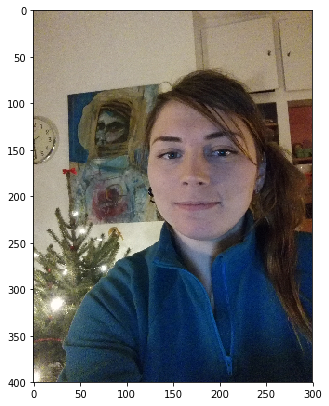

In [8]:
show_img(me, figsize=(5, 10))

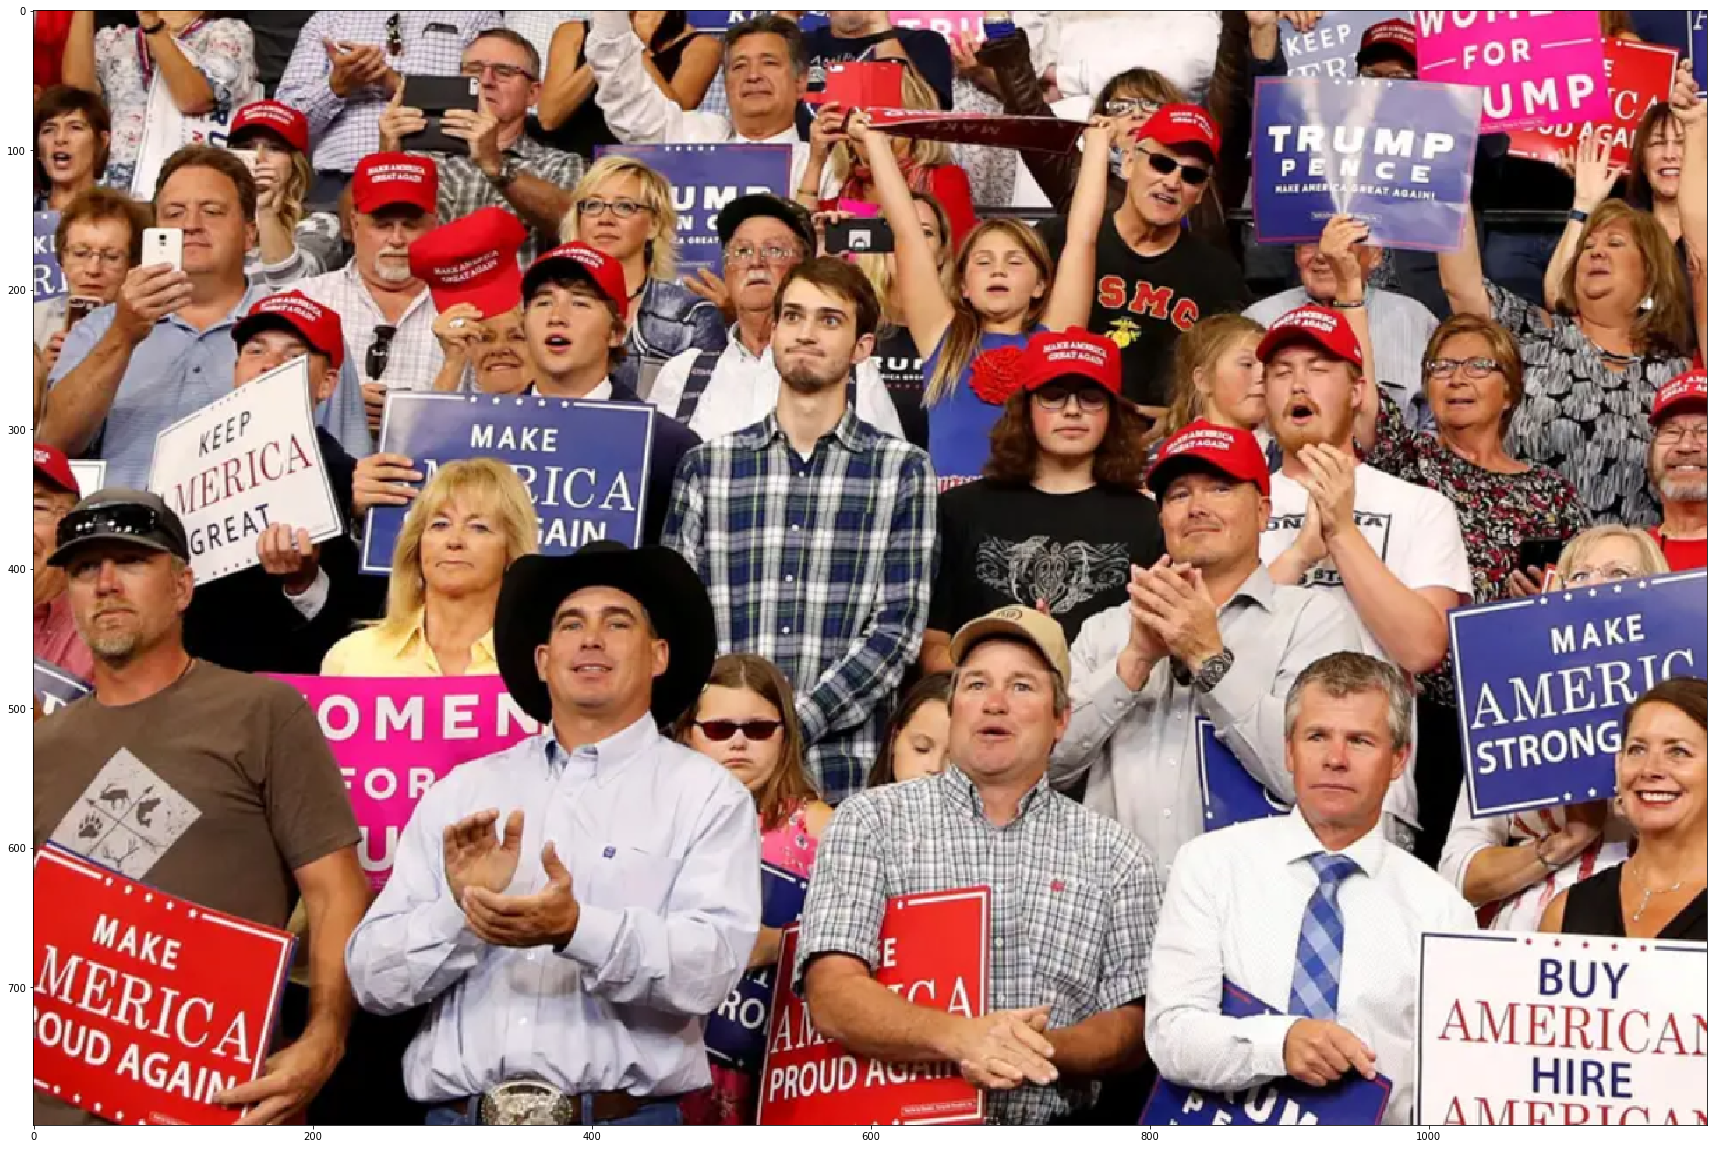

In [9]:
show_img(crowd, figsize=(30, 60))

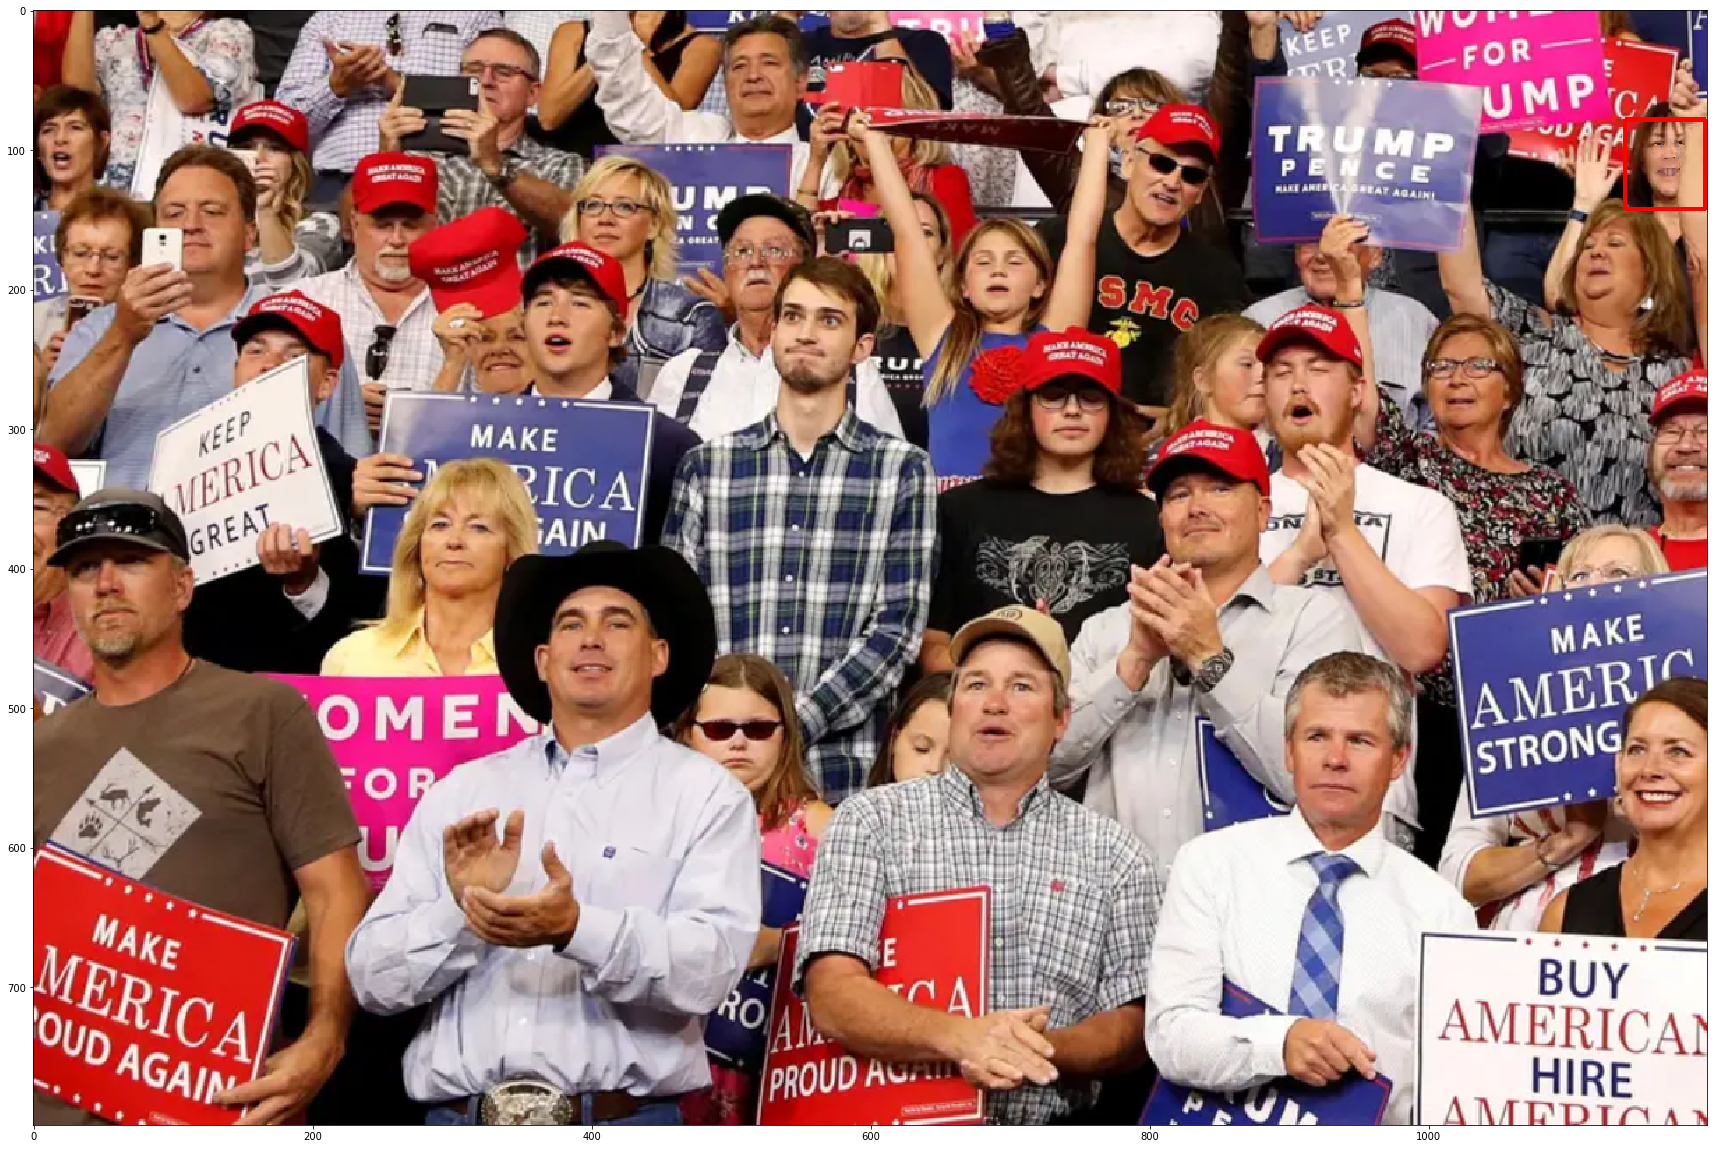

In [10]:
show_img(output_labeled, figsize=(30, 60))

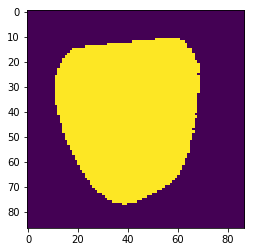

In [75]:
plt.imshow(mask)

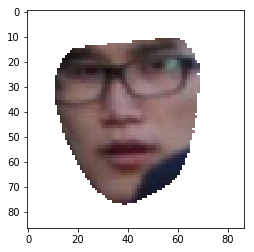

In [76]:
plt.imshow(np.concatenate([dst_face, mask[:, :, np.newaxis]], axis=2))

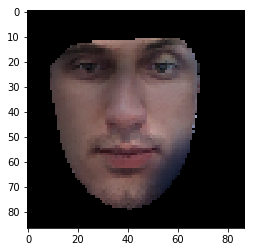

In [77]:
plt.imshow(warped_src_face)

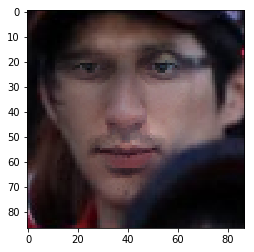

In [78]:
plt.imshow(new_output)

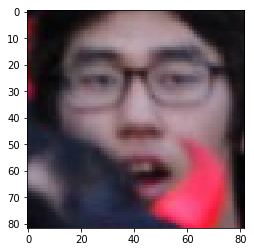

In [173]:
n = 7

plt.imshow(crops[n])
plt.show()

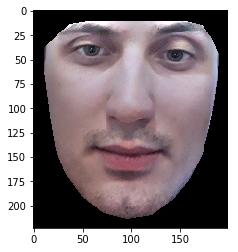

In [23]:
plt.imshow(src_face)

In [35]:
points = face_detection(me)[0]
me_cropped = me[points[1]:points[3], points[0]:points[2]]

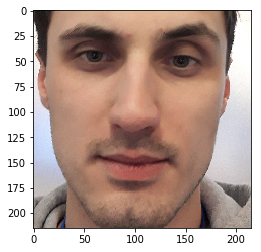

In [79]:
plt.imshow(me_cropped)
plt.show()

In [37]:
cv2.imwrite("./data/me_cropped.jpg", me_cropped)

True

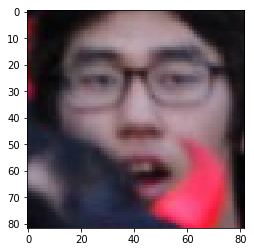

In [173]:
n = 7

plt.imshow(crops[n])
plt.show()

### Facenet approach: